In [1]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import random
import os
import cv2
from tqdm import tqdm

from utils.pycoco import *
os.environ['DATASETS_DIR'] = 'D:\\Reza\\Dokumen\\datasets\\'

In [2]:
from keras.optimizers import Adam

Using TensorFlow backend.


In [3]:
from utils.data_loader import Dataset, Dataloader
from utils.augmentation import *
import segmentation_models as sm
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

Segmentation Models: using `keras` framework.


In [4]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [5]:
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

In [6]:
classes = ['person']
DATA_DIR = os.path.join(os.environ['DATASETS_DIR'] , 'coco\\val2017\\')
ANOTATION_FILE = os.path.join(os.environ['DATASETS_DIR'] , 'coco\\annotations\\instances_val2017.json')
images, dataset_size, coco = filterDataset(ANOTATION_FILE, classes)
# coco = COCO(os.path.join(os.environ['DATASETS_DIR'] , 'coco\\annotations\\instances_val2017.json'))

loading annotations into memory...
Done (t=0.81s)
creating index...
index created!


In [7]:
imageObj = images[6]
catIds = coco.getCatIds(catNms=classes)

img_folder = ''
for dir_ in [DATA_DIR]:
    if os.path.isfile('{}/{}'.format(dir_,imageObj['file_name'])):
        img_folder = dir_
        break
        
### Retrieve Image ###
train_img = getImage(imageObj, img_folder)

In [8]:
mask = getNormalMask(imageObj, classes, coco, catIds, train_img.shape[:2])

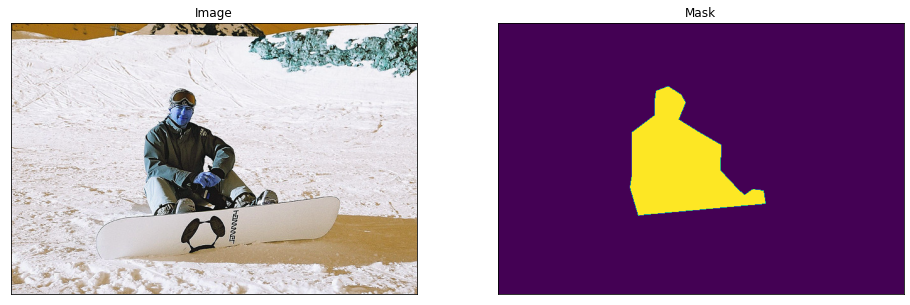

In [9]:
visualize(image = train_img,
            mask = mask)

In [6]:
# Directorios
train_dir = './data/train/'
test_dir = './data/val/'

x_train_dir = os.path.join(train_dir, 'image')
y_train_dir = os.path.join(train_dir, 'mask')
x_valid_dir = os.path.join(test_dir, 'image')
y_valid_dir = os.path.join(test_dir, 'mask')

MODEL_FILE = './model/model.h5'

# define network parameters 
BACKBONE = 'efficientnetb3'
classes = ['person']
n_classes = 1 if len(classes) == 1 else (len(classes) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'
preprocess_input = sm.get_preprocessing(BACKBONE)

#Model parameters
BATCH_SIZE = 2
LR = 0.0005
EPOCHS = 10

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=classes,
    preprocessing=get_preprocessing(preprocess_input),
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


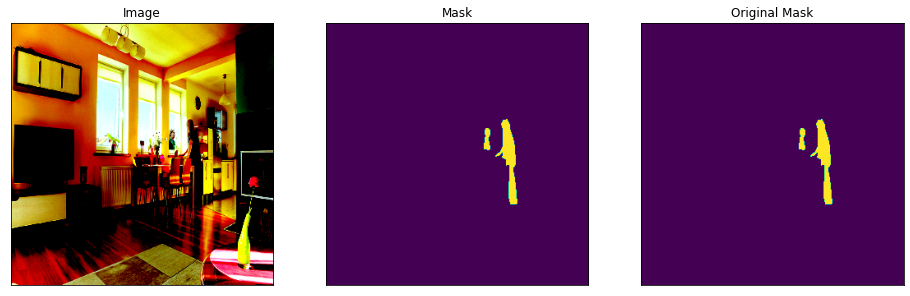

In [7]:
image, mask = valid_dataset[0]

visualize(
    image=image,
    mask=mask
)

In [8]:
mask.shape

(320, 320, 1)

In [8]:
x = mask.flatten()

In [9]:
x.shape

(102400,)

In [10]:
df = pd.DataFrame({'x':x})

In [11]:
df['x'].value_counts()

0      101113
255      1287
Name: x, dtype: int64

In [12]:
# define optomizer
optim = Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss() 
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)
model.load_weights(MODEL_FILE)
model.compile(optim, total_loss, metrics)












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.






In [13]:
prediction = model.predict(np.expand_dims(image, axis=0))

In [14]:
prediction[..., 0].max()

0.9972513

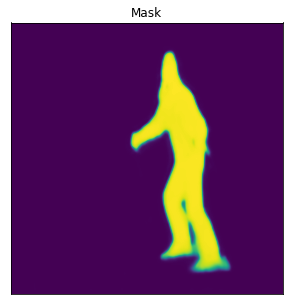

In [15]:
visualize(
    mask=prediction[0]
)